# 베스트셀러 체류 분석 & 카테고리별 바이럴 민감도 분석

## 분석 개요

### 1. 베스트셀러 체류 분석
- 도서별 베스트셀러 리스트 체류 기간 분석
- 롱셀러 vs 단기 베스트셀러 특성 비교
- 카테고리별 평균 체류 기간

### 2. 카테고리별 바이럴 민감도 분석
- 카테고리별 바이럴 지수-판매 점수 상관계수 비교
- 바이럴 지수 변화에 따른 판매 변화 계수 비교
- 어떤 카테고리가 뉴스 바이럴에 민감/둔감한지 분석

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료")

라이브러리 로드 완료


In [2]:
# 데이터 로드
ml_data = pd.read_csv('books_ml_dataset_v3.csv')
viral_data = pd.read_csv('../weekly_news_viral_index.csv')
bestseller_data = pd.read_csv('../weekly_bestseller_scores_decay.csv')

print(f"ML 데이터: {ml_data.shape}")
print(f"바이럴 데이터: {viral_data.shape}")
print(f"베스트셀러 데이터: {bestseller_data.shape}")

ML 데이터: (7191, 46)
바이럴 데이터: (572, 8)
베스트셀러 데이터: (494, 3)


---
## Part 1: 베스트셀러 체류 분석

In [3]:
# 베스트셀러 체류 분석을 위한 데이터 준비
# y_sales_score > 0인 경우 해당 주에 베스트셀러에 있었던 것

# 도서별 베스트셀러 등장 횟수 계산
book_presence = ml_data.groupby('product_code').agg({
    'ymw': 'count',  # 전체 데이터 포인트 수
    'y_sales_score': lambda x: (x > 0).sum()  # 베스트셀러에 있었던 주 수
}).reset_index()

book_presence.columns = ['product_code', 'total_weeks', 'bestseller_weeks']

# 베스트셀러에 한 번이라도 등장한 도서만 필터링
book_presence = book_presence[book_presence['bestseller_weeks'] > 0]

print(f"베스트셀러에 등장한 도서 수: {len(book_presence)}")
print(f"\n체류 기간 통계:")
print(book_presence['bestseller_weeks'].describe())

베스트셀러에 등장한 도서 수: 139

체류 기간 통계:
count    139.000000
mean      11.611511
std        8.336675
min        4.000000
25%        7.000000
50%        9.000000
75%       13.500000
max       51.000000
Name: bestseller_weeks, dtype: float64


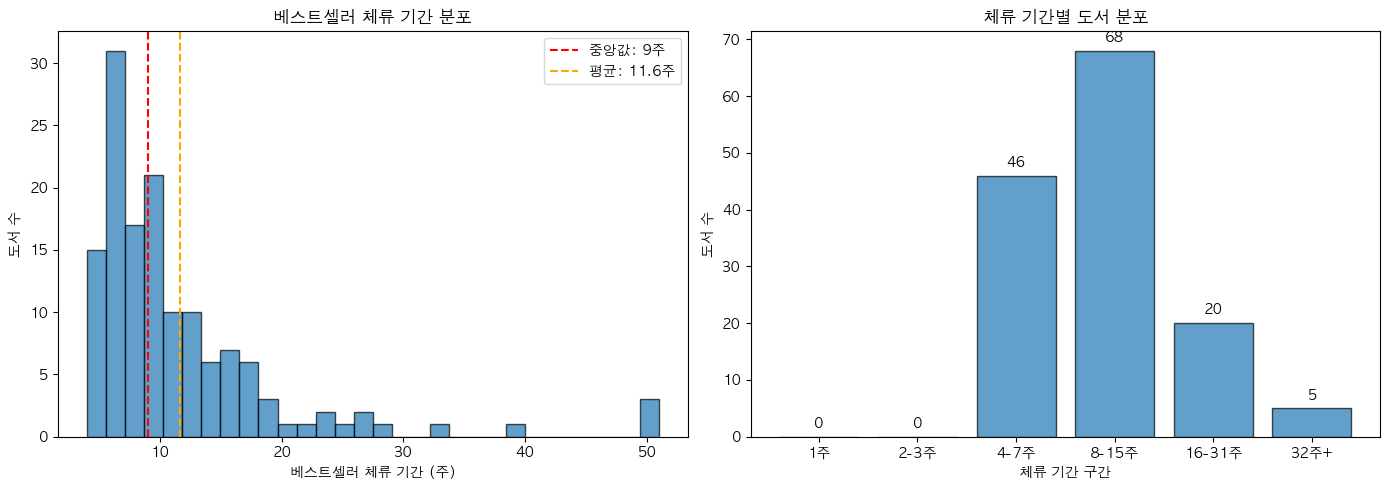


체류 기간별 도서 수:
retention_group
1주         0
2-3주       0
4-7주      46
8-15주     68
16-31주    20
32주+       5
Name: count, dtype: int64


In [4]:
# 체류 기간 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(book_presence['bestseller_weeks'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(book_presence['bestseller_weeks'].median(), color='red', linestyle='--', label=f'중앙값: {book_presence["bestseller_weeks"].median():.0f}주')
axes[0].axvline(book_presence['bestseller_weeks'].mean(), color='orange', linestyle='--', label=f'평균: {book_presence["bestseller_weeks"].mean():.1f}주')
axes[0].set_xlabel('베스트셀러 체류 기간 (주)')
axes[0].set_ylabel('도서 수')
axes[0].set_title('베스트셀러 체류 기간 분포')
axes[0].legend()

# 체류 기간별 도서 수 (구간별)
bins = [1, 2, 4, 8, 16, 32, 100]
labels = ['1주', '2-3주', '4-7주', '8-15주', '16-31주', '32주+']
book_presence['retention_group'] = pd.cut(book_presence['bestseller_weeks'], bins=bins, labels=labels, right=False)
retention_counts = book_presence['retention_group'].value_counts().sort_index()

bars = axes[1].bar(retention_counts.index, retention_counts.values, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('체류 기간 구간')
axes[1].set_ylabel('도서 수')
axes[1].set_title('체류 기간별 도서 분포')

# 막대 위에 수치 표시
for bar, count in zip(bars, retention_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{count}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n체류 기간별 도서 수:")
print(retention_counts)

In [5]:
# 도서별 주요 카테고리 파악
category_cols = [col for col in ml_data.columns if col.startswith('category_') and not col.endswith('_viral_index')]
category_names = {
    'category_1': '거시경제/금융정책',
    'category_2': '경제이론/학술',
    'category_3': '금융시스템/위기',
    'category_4': '기업경영/리더십',
    'category_5': '부동산/실물자산',
    'category_6': '재테크/개인금융',
    'category_7': '주식투자/트레이딩',
    'category_8': '지정학/국제정세',
    'category_9': '테크/스타트업',
    'category_10': '투자철학/대가'
}

# 각 도서의 주요 카테고리 결정 (가장 높은 비율의 카테고리)
def get_primary_category(row):
    cat_values = {cat: row[cat] for cat in category_cols}
    primary = max(cat_values, key=cat_values.get)
    return category_names.get(primary, primary)

# 도서별 첫 번째 행에서 카테고리 정보 가져오기
book_categories = ml_data.groupby('product_code').first()[category_cols].reset_index()
book_categories['primary_category'] = book_categories.apply(get_primary_category, axis=1)

# 체류 정보와 병합
book_retention = book_presence.merge(book_categories[['product_code', 'primary_category']], on='product_code')

print("도서별 주요 카테고리 분포:")
print(book_retention['primary_category'].value_counts())

도서별 주요 카테고리 분포:
primary_category
기업경영/리더십     39
주식투자/트레이딩    32
지정학/국제정세     16
재테크/개인금융     11
테크/스타트업      11
투자철학/대가       8
거시경제/금융정책     8
부동산/실물자산      7
금융시스템/위기      4
경제이론/학술       3
Name: count, dtype: int64


카테고리별 베스트셀러 체류 기간:
                  평균 체류(주)  중앙값(주)   표준편차  도서 수
primary_category                               
경제이론/학술              27.67    26.0  21.55     3
투자철학/대가              18.12    16.0  14.80     8
재테크/개인금융             13.27     7.0  12.61    11
금융시스템/위기             12.50    10.5   8.58     4
거시경제/금융정책            12.12    10.5   5.46     8
지정학/국제정세             11.56    11.5   4.05    16
주식투자/트레이딩            11.19     9.0   8.19    32
테크/스타트업              10.09     9.0   3.73    11
기업경영/리더십              9.95     8.0   5.65    39
부동산/실물자산              7.29     8.0   1.60     7


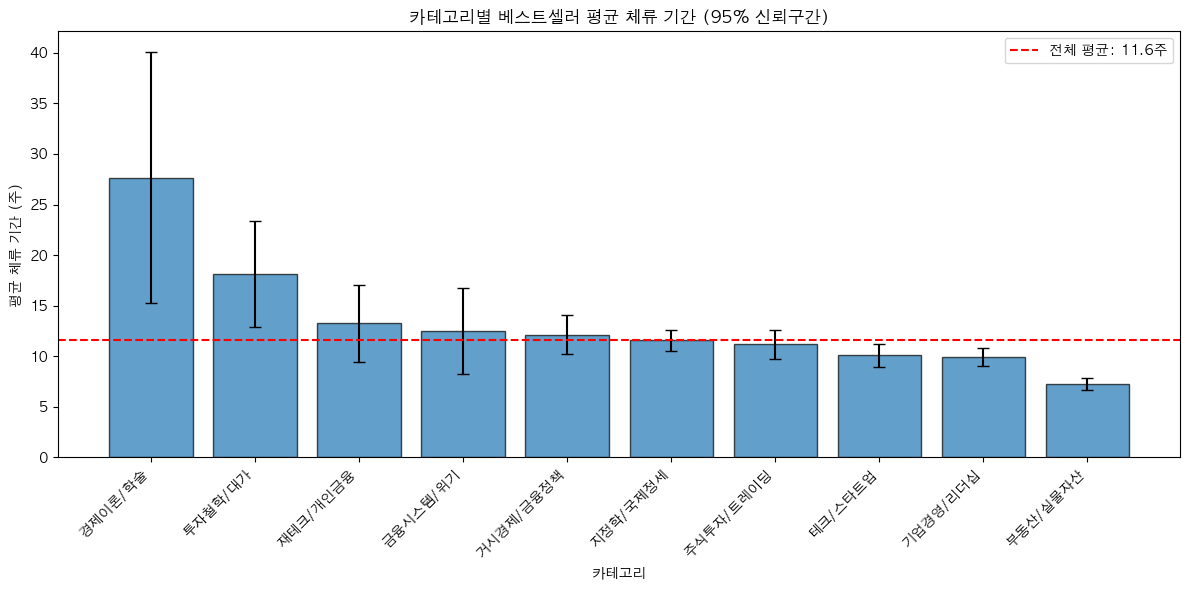

In [6]:
# 카테고리별 평균 체류 기간
category_retention = book_retention.groupby('primary_category')['bestseller_weeks'].agg(['mean', 'median', 'std', 'count']).round(2)
category_retention = category_retention.sort_values('mean', ascending=False)
category_retention.columns = ['평균 체류(주)', '중앙값(주)', '표준편차', '도서 수']

print("카테고리별 베스트셀러 체류 기간:")
print(category_retention)

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(category_retention))
bars = ax.bar(x, category_retention['평균 체류(주)'], yerr=category_retention['표준편차']/np.sqrt(category_retention['도서 수']),
              capsize=4, edgecolor='black', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(category_retention.index, rotation=45, ha='right')
ax.set_xlabel('카테고리')
ax.set_ylabel('평균 체류 기간 (주)')
ax.set_title('카테고리별 베스트셀러 평균 체류 기간 (95% 신뢰구간)')

# 전체 평균선
overall_mean = book_retention['bestseller_weeks'].mean()
ax.axhline(overall_mean, color='red', linestyle='--', label=f'전체 평균: {overall_mean:.1f}주')
ax.legend()

plt.tight_layout()
plt.show()

In [7]:
# 롱셀러 vs 단기 베스트셀러 분석
# 롱셀러: 8주 이상 체류, 단기: 3주 이하 체류

longseller = book_retention[book_retention['bestseller_weeks'] >= 8]
shortseller = book_retention[book_retention['bestseller_weeks'] <= 3]

print(f"롱셀러 (8주+): {len(longseller)}권")
print(f"단기 베스트셀러 (3주 이하): {len(shortseller)}권")

# 카테고리별 롱셀러 비율
category_longseller = book_retention.groupby('primary_category').apply(
    lambda x: (x['bestseller_weeks'] >= 8).sum() / len(x) * 100
).sort_values(ascending=False)

print("\n카테고리별 롱셀러(8주+) 비율:")
for cat, pct in category_longseller.items():
    print(f"  {cat}: {pct:.1f}%")

롱셀러 (8주+): 93권
단기 베스트셀러 (3주 이하): 0권

카테고리별 롱셀러(8주+) 비율:
  거시경제/금융정책: 87.5%
  지정학/국제정세: 81.2%
  투자철학/대가: 75.0%
  테크/스타트업: 72.7%
  주식투자/트레이딩: 68.8%
  경제이론/학술: 66.7%
  기업경영/리더십: 61.5%
  부동산/실물자산: 57.1%
  금융시스템/위기: 50.0%
  재테크/개인금융: 45.5%


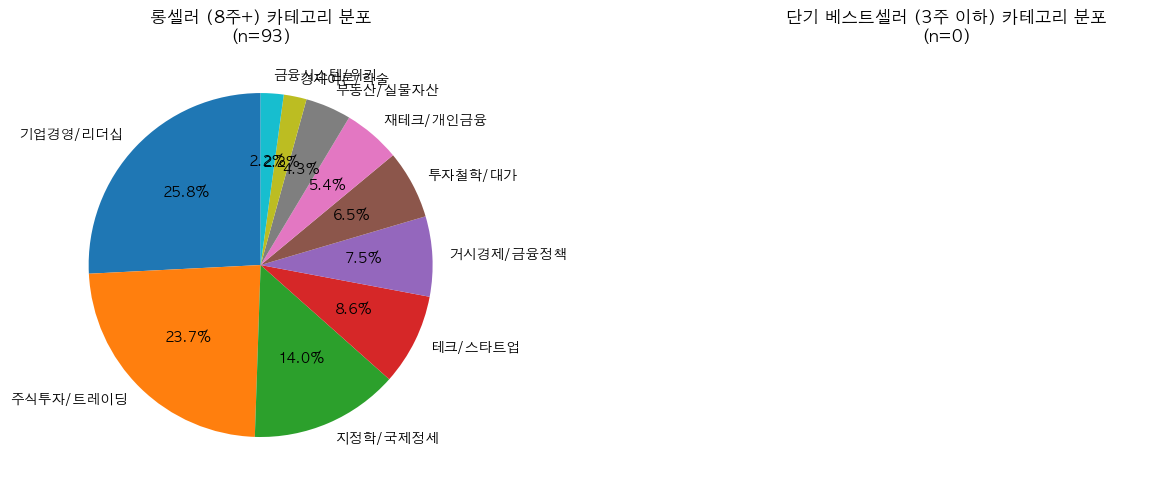

In [8]:
# 롱셀러 vs 단기 베스트셀러 카테고리 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 롱셀러 카테고리 분포
longseller_cats = longseller['primary_category'].value_counts()
axes[0].pie(longseller_cats.values, labels=longseller_cats.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title(f'롱셀러 (8주+) 카테고리 분포\n(n={len(longseller)})')

# 단기 베스트셀러 카테고리 분포
shortseller_cats = shortseller['primary_category'].value_counts()
axes[1].pie(shortseller_cats.values, labels=shortseller_cats.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title(f'단기 베스트셀러 (3주 이하) 카테고리 분포\n(n={len(shortseller)})')

plt.tight_layout()
plt.show()

---
## Part 2: 카테고리별 바이럴 민감도 분석

In [9]:
# 바이럴 데이터 준비
# 카테고리별 바이럴 지수와 판매 점수의 상관관계 분석

# 미분류 제외
viral_filtered = viral_data[viral_data['category'] != '미분류'].copy()
bestseller_filtered = bestseller_data.copy()

# 병합
merged = viral_filtered.merge(bestseller_filtered, on=['ymw', 'category'], how='inner')

print(f"병합된 데이터: {merged.shape}")
print(f"카테고리 목록: {merged["category"].unique()}")

병합된 데이터: (485, 9)
카테고리 목록: ['거시경제/금융정책' '경제이론/학술' '금융시스템/위기' '부동산/실물자산' '재테크/개인금융' '주식투자/트레이딩'
 '지정학/국제정세' '테크/스타트업' '투자철학/대가' '기업경영/리더십']


In [10]:
# 카테고리별 바이럴 지수-판매 점수 상관계수 계산
correlation_results = []

for category in merged['category'].unique():
    cat_data = merged[merged['category'] == category]
    
    # 상관계수 계산
    corr_viral = cat_data['viral_index'].corr(cat_data['sales_score'])
    corr_viral_smoothed = cat_data['viral_index_smoothed'].corr(cat_data['sales_score'])
    
    # 회귀 계수 계산 (바이럴 지수 1단위 변화 -> 판매 점수 변화)
    if len(cat_data) > 2:
        X = cat_data[['viral_index_smoothed']].values
        y = cat_data['sales_score'].values
        reg = LinearRegression().fit(X, y)
        coef = reg.coef_[0]
    else:
        coef = np.nan
    
    correlation_results.append({
        'category': category,
        'corr_viral': corr_viral,
        'corr_viral_smoothed': corr_viral_smoothed,
        'regression_coef': coef,
        'n_weeks': len(cat_data),
        'avg_sales': cat_data['sales_score'].mean(),
        'avg_viral': cat_data['viral_index_smoothed'].mean()
    })

corr_df = pd.DataFrame(correlation_results)
corr_df = corr_df.sort_values('corr_viral_smoothed', ascending=False)

print("카테고리별 바이럴-판매 상관계수:")
print(corr_df.round(3).to_string(index=False))

카테고리별 바이럴-판매 상관계수:
 category  corr_viral  corr_viral_smoothed  regression_coef  n_weeks  avg_sales  avg_viral
 지정학/국제정세       0.137                0.338            0.068       44     12.063     18.023
 재테크/개인금융       0.124                0.183            0.042       50     40.545     17.966
 기업경영/리더십       0.151                0.108            0.030       48     12.185     16.671
  경제이론/학술       0.073                0.101            0.014       50      9.989     20.434
거시경제/금융정책      -0.003                0.090            0.025       50     32.564     23.252
 금융시스템/위기       0.067                0.050            0.011       47     12.965     16.474
  테크/스타트업      -0.039                0.008            0.001       50     14.168     20.347
주식투자/트레이딩       0.055                0.003            0.001       50     62.252     19.863
 부동산/실물자산      -0.046               -0.134           -0.033       46     12.753     20.204
  투자철학/대가      -0.140               -0.143           -0.031       50   

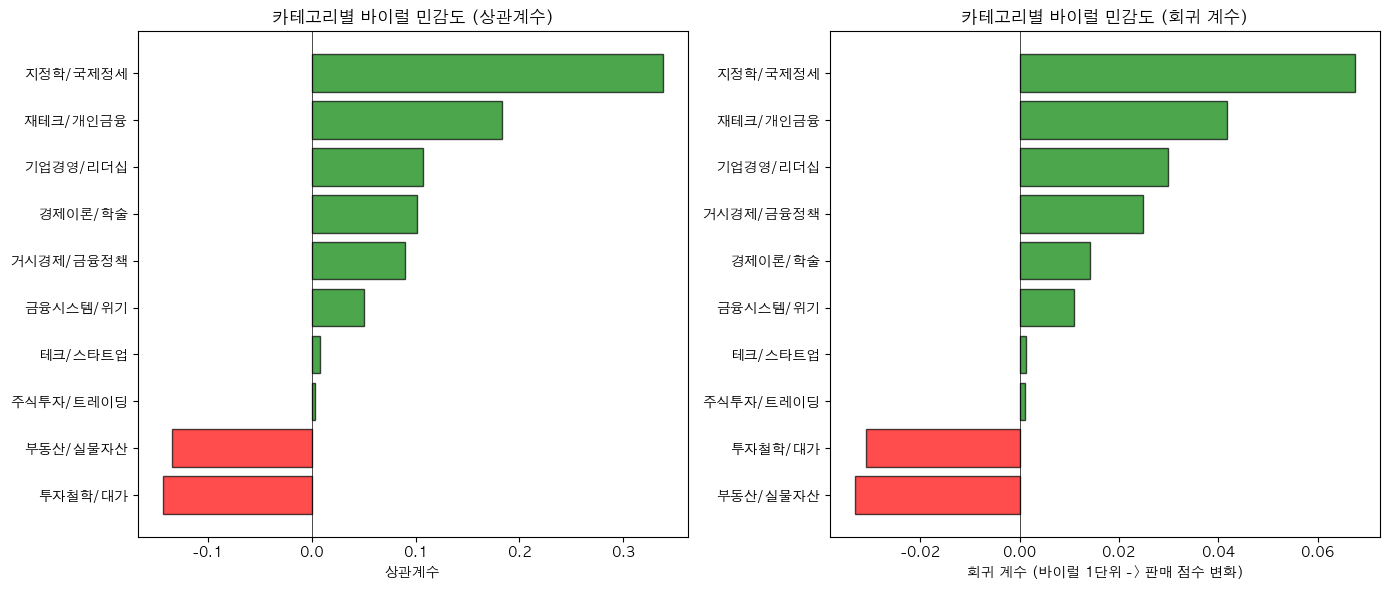

In [11]:
# 바이럴 민감도 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. 상관계수 비교
corr_sorted = corr_df.sort_values('corr_viral_smoothed', ascending=True)
colors = ['green' if x > 0 else 'red' for x in corr_sorted['corr_viral_smoothed']]

axes[0].barh(corr_sorted['category'], corr_sorted['corr_viral_smoothed'], color=colors, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].set_xlabel('상관계수')
axes[0].set_title('카테고리별 바이럴 민감도 (상관계수)')

# 2. 회귀 계수 비교
coef_sorted = corr_df.sort_values('regression_coef', ascending=True)
colors2 = ['green' if x > 0 else 'red' for x in coef_sorted['regression_coef']]

axes[1].barh(coef_sorted['category'], coef_sorted['regression_coef'], color=colors2, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].set_xlabel('회귀 계수 (바이럴 1단위 -> 판매 점수 변화)')
axes[1].set_title('카테고리별 바이럴 민감도 (회귀 계수)')

plt.tight_layout()
plt.show()

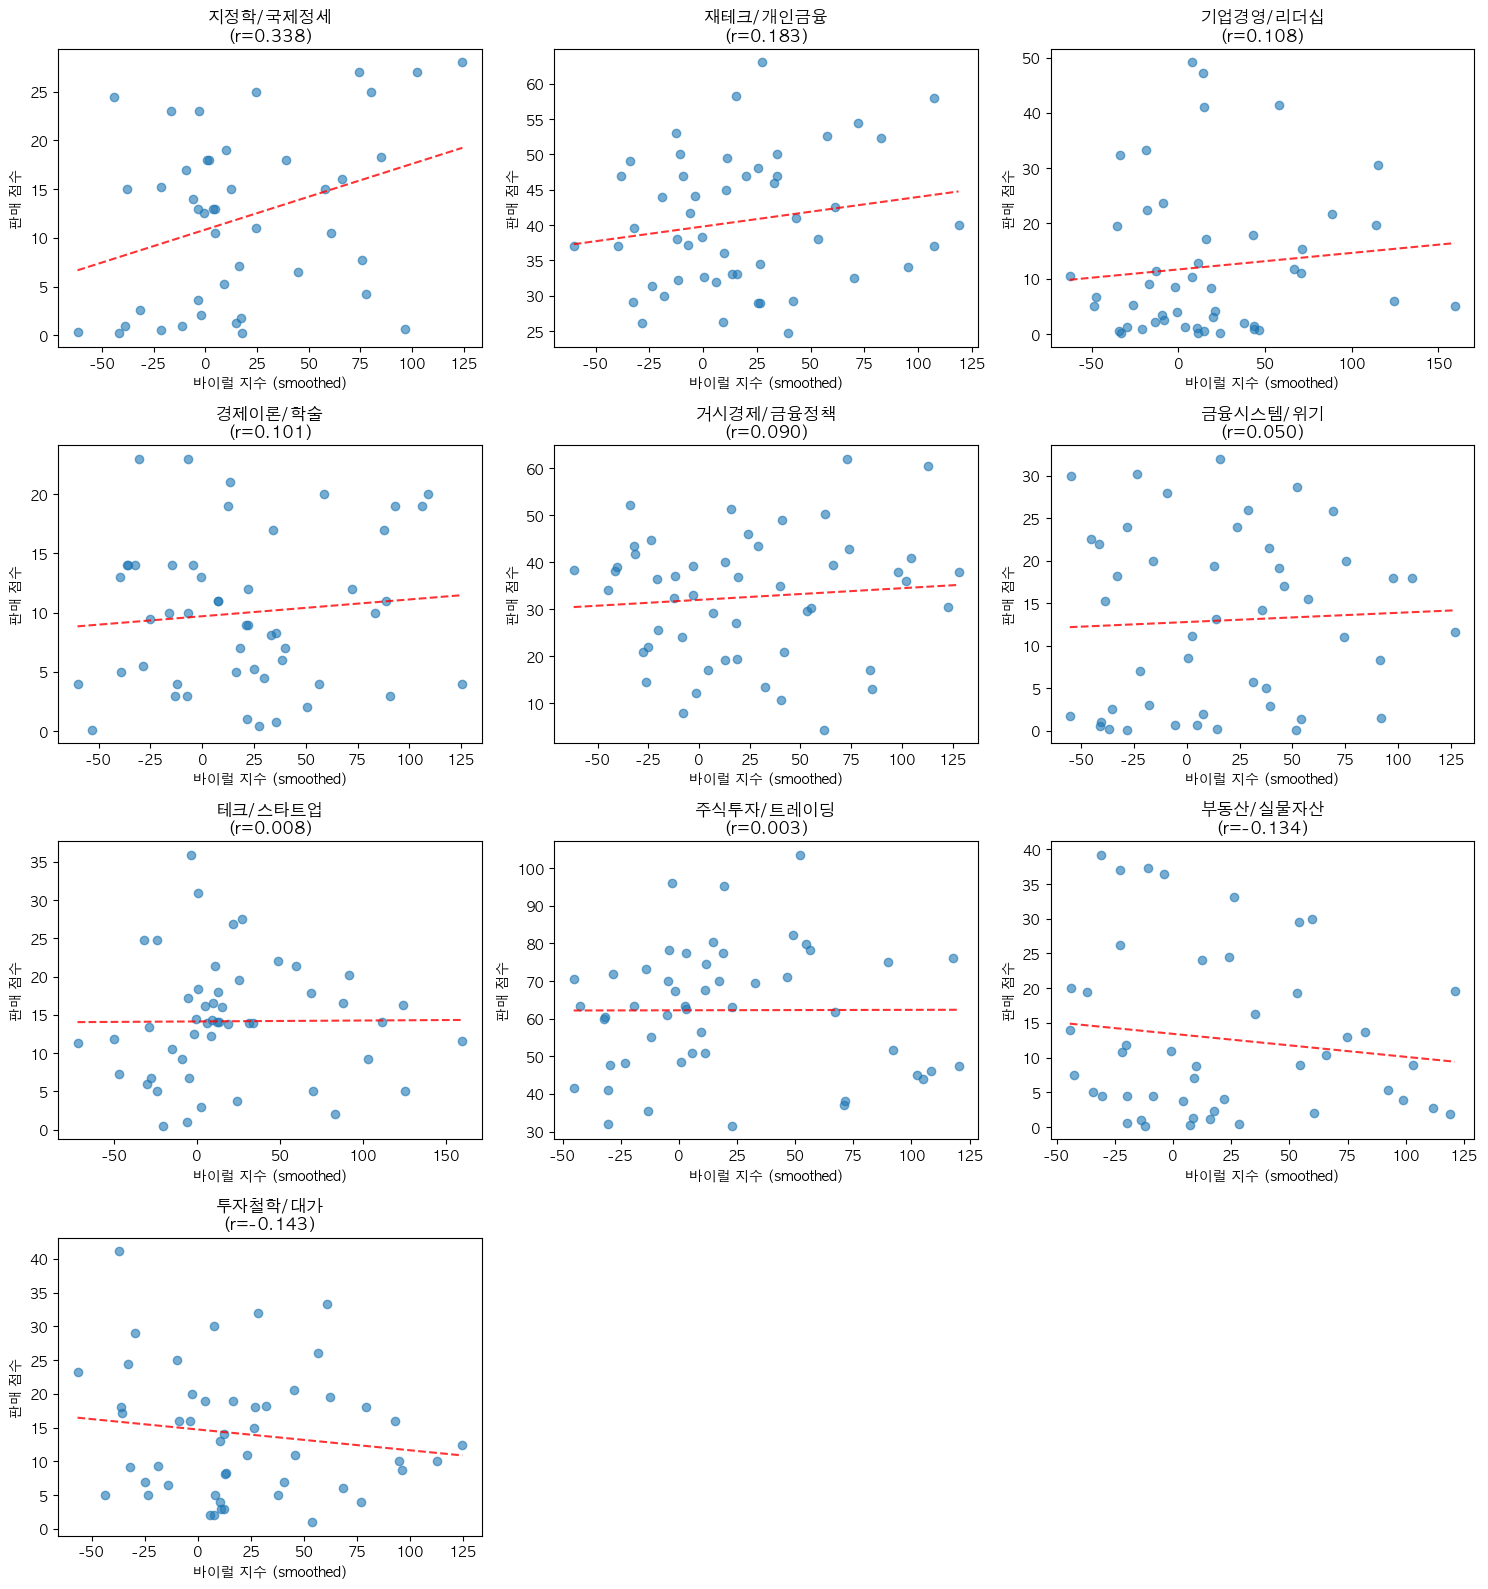

In [12]:
# 카테고리별 산점도 (바이럴 vs 판매)
categories = corr_df['category'].tolist()
n_cats = len(categories)
n_cols = 3
n_rows = (n_cats + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, category in enumerate(categories):
    cat_data = merged[merged['category'] == category]
    corr = corr_df[corr_df['category'] == category]['corr_viral_smoothed'].values[0]
    
    axes[i].scatter(cat_data['viral_index_smoothed'], cat_data['sales_score'], alpha=0.6)
    
    # 추세선
    z = np.polyfit(cat_data['viral_index_smoothed'], cat_data['sales_score'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(cat_data['viral_index_smoothed'].min(), cat_data['viral_index_smoothed'].max(), 100)
    axes[i].plot(x_line, p(x_line), 'r--', alpha=0.8)
    
    axes[i].set_xlabel('바이럴 지수 (smoothed)')
    axes[i].set_ylabel('판매 점수')
    axes[i].set_title(f'{category}\n(r={corr:.3f})')

# 빈 subplot 숨기기
for i in range(n_cats, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [13]:
# 민감도 그룹 분류
def classify_sensitivity(row):
    if row['corr_viral_smoothed'] > 0.3:
        return '높은 민감도'
    elif row['corr_viral_smoothed'] > 0:
        return '낮은 민감도'
    else:
        return '역관계'

corr_df['sensitivity_group'] = corr_df.apply(classify_sensitivity, axis=1)

print("\n===== 바이럴 민감도 그룹 분류 =====")
for group in ['높은 민감도', '낮은 민감도', '역관계']:
    group_cats = corr_df[corr_df['sensitivity_group'] == group]['category'].tolist()
    if group_cats:
        print(f"\n{group}:")
        for cat in group_cats:
            corr_val = corr_df[corr_df['category'] == cat]['corr_viral_smoothed'].values[0]
            print(f"  - {cat} (r={corr_val:.3f})")


===== 바이럴 민감도 그룹 분류 =====

높은 민감도:
  - 지정학/국제정세 (r=0.338)

낮은 민감도:
  - 재테크/개인금융 (r=0.183)
  - 기업경영/리더십 (r=0.108)
  - 경제이론/학술 (r=0.101)
  - 거시경제/금융정책 (r=0.090)
  - 금융시스템/위기 (r=0.050)
  - 테크/스타트업 (r=0.008)
  - 주식투자/트레이딩 (r=0.003)

역관계:
  - 부동산/실물자산 (r=-0.134)
  - 투자철학/대가 (r=-0.143)


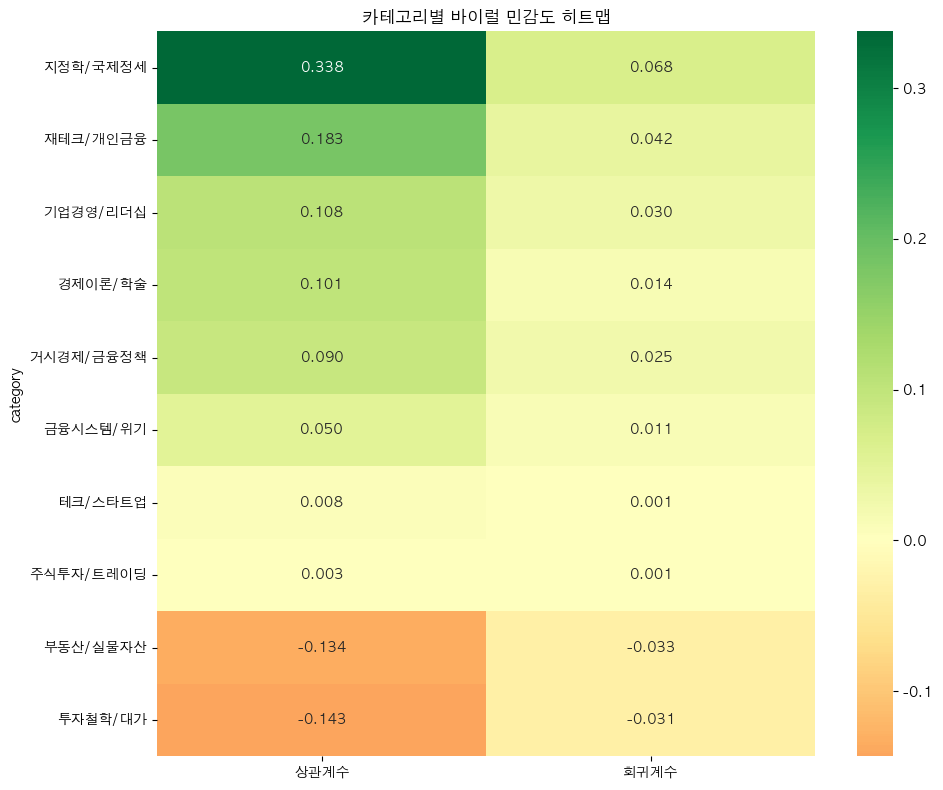

In [14]:
# 히트맵: 바이럴 민감도 요약
fig, ax = plt.subplots(figsize=(10, 8))

# 상관계수와 회귀계수를 함께 표시
heatmap_data = corr_df.set_index('category')[['corr_viral_smoothed', 'regression_coef']].copy()
heatmap_data.columns = ['상관계수', '회귀계수']

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=ax)
ax.set_title('카테고리별 바이럴 민감도 히트맵')

plt.tight_layout()
plt.show()

---
## 분석 결과 요약

In [15]:
print("="*60)
print("분석 결과 요약")
print("="*60)

print("\n[1. 베스트셀러 체류 분석]")
print(f"  - 분석 도서 수: {len(book_retention)}권")
print(f"  - 평균 체류 기간: {book_retention['bestseller_weeks'].mean():.1f}주")
print(f"  - 중앙값 체류 기간: {book_retention['bestseller_weeks'].median():.0f}주")
print(f"  - 롱셀러(8주+) 비율: {len(longseller)/len(book_retention)*100:.1f}%")
print(f"  - 단기(3주 이하) 비율: {len(shortseller)/len(book_retention)*100:.1f}%")

print("\n  체류 기간이 가장 긴 카테고리:")
top3_retention = category_retention.head(3)
for idx, (cat, row) in enumerate(top3_retention.iterrows(), 1):
    print(f"    {idx}. {cat}: 평균 {row['평균 체류(주)']:.1f}주")

print("\n[2. 카테고리별 바이럴 민감도 분석]")

high_sens = corr_df[corr_df['sensitivity_group'] == '높은 민감도']
if len(high_sens) > 0:
    print("\n  바이럴에 민감한 카테고리 (r > 0.3):")
    for _, row in high_sens.iterrows():
        print(f"    - {row['category']}: r={row['corr_viral_smoothed']:.3f}")

low_sens = corr_df[corr_df['sensitivity_group'] == '낮은 민감도']
if len(low_sens) > 0:
    print("\n  바이럴에 약하게 반응하는 카테고리 (0 < r <= 0.3):")
    for _, row in low_sens.iterrows():
        print(f"    - {row['category']}: r={row['corr_viral_smoothed']:.3f}")

neg_sens = corr_df[corr_df['sensitivity_group'] == '역관계']
if len(neg_sens) > 0:
    print("\n  바이럴과 역관계인 카테고리 (r < 0):")
    for _, row in neg_sens.iterrows():
        print(f"    - {row['category']}: r={row['corr_viral_smoothed']:.3f}")

print("\n" + "="*60)

분석 결과 요약

[1. 베스트셀러 체류 분석]
  - 분석 도서 수: 139권
  - 평균 체류 기간: 11.6주
  - 중앙값 체류 기간: 9주
  - 롱셀러(8주+) 비율: 66.9%
  - 단기(3주 이하) 비율: 0.0%

  체류 기간이 가장 긴 카테고리:
    1. 경제이론/학술: 평균 27.7주
    2. 투자철학/대가: 평균 18.1주
    3. 재테크/개인금융: 평균 13.3주

[2. 카테고리별 바이럴 민감도 분석]

  바이럴에 민감한 카테고리 (r > 0.3):
    - 지정학/국제정세: r=0.338

  바이럴에 약하게 반응하는 카테고리 (0 < r <= 0.3):
    - 재테크/개인금융: r=0.183
    - 기업경영/리더십: r=0.108
    - 경제이론/학술: r=0.101
    - 거시경제/금융정책: r=0.090
    - 금융시스템/위기: r=0.050
    - 테크/스타트업: r=0.008
    - 주식투자/트레이딩: r=0.003

  바이럴과 역관계인 카테고리 (r < 0):
    - 부동산/실물자산: r=-0.134
    - 투자철학/대가: r=-0.143



In [16]:
# 결과 저장
category_retention.to_csv('category_retention_analysis.csv')
corr_df.to_csv('category_viral_sensitivity.csv', index=False)
book_retention.to_csv('book_retention_data.csv', index=False)

print("결과 파일 저장 완료:")
print("  - category_retention_analysis.csv")
print("  - category_viral_sensitivity.csv")
print("  - book_retention_data.csv")

결과 파일 저장 완료:
  - category_retention_analysis.csv
  - category_viral_sensitivity.csv
  - book_retention_data.csv
